In [1]:
import pandas as pd
import mplfinance as mpf
from regime_detection import get_msm, identify_bull_bear_states, get_transition_counts, dating, assign_regimes
import numpy as np
from deeptime import markov
from utils import generate_ar_weights, indicator_signal
import random
import matplotlib.pyplot as plt
from trend import generate_signals, get_action_dates, plot_actions

In [2]:
random.seed(42)

In [3]:
symbol = 'JINDALSAW'
df = pd.read_csv(f'../data/symbols/{symbol}.csv')
data = df[['date', 'returns']]
data['returns'] = data['returns']
data['date'] = pd.to_datetime(df['date'])
data.set_index(data['date'], inplace=True)
data.describe()

C:\Users\adity\AppData\Local\Temp\ipykernel_28796\978026016.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['returns'] = data['returns']
C:\Users\adity\AppData\Local\Temp\ipykernel_28796\978026016.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(df['date'])


,returns
count,126.000000
mean,0.024016
std,0.143634
min,-0.397368
25%,-0.067370
50%,0.014240
75%,0.111046
max,0.486553


In [4]:
split = 0.7
train_data, test_data = data[:int(split*len(data))], data[int(split*len(data)):]
test_data = test_data.reset_index(drop=True)

<Axes: xlabel='date'>

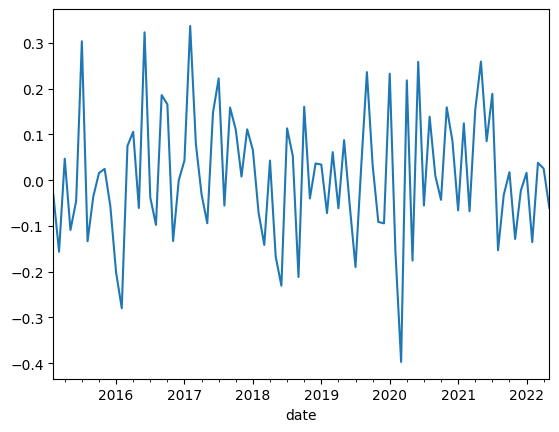

In [5]:
train_data['returns'].plot()

(array([ 1.,  1.,  4., 11., 23., 16., 13., 10.,  6.,  3.]),
 array([-0.39736842, -0.32389455, -0.25042069, -0.17694682, -0.10347296,
        -0.02999909,  0.04347478,  0.11694864,  0.19042251,  0.26389638,
         0.33737024]),
 <BarContainer object of 10 artists>)

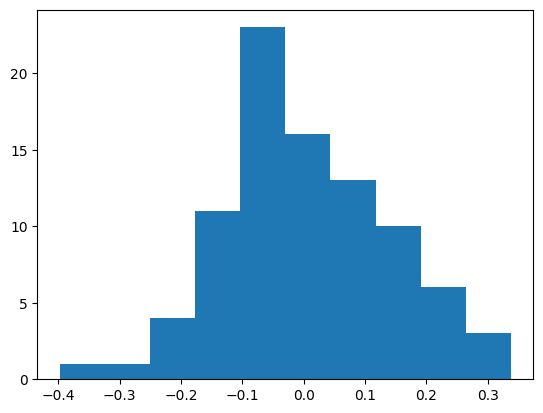

In [6]:
plt.hist(train_data['returns'])

In [7]:
tp = dating(pd.Series(train_data['returns']))

In [8]:
tp

[<T: 2016-02: -0.28>,
 <P: 2017-02: 0.34>,
 <T: 2018-06: -0.23>,
 <P: 2019-09: 0.24>,
 <T: 2020-03: -0.40>,
 <P: 2021-05: 0.26>]

In [9]:
assign_regimes(train_data, tp)

2016-02-01 00:00:00+05:30 2016-02-01 00:00:00+05:30
2017-02-01 00:00:00+05:30 2017-02-01 00:00:00+05:30
2018-06-01 00:00:00+05:30 2018-06-01 00:00:00+05:30
2019-09-01 00:00:00+05:30 2019-09-01 00:00:00+05:30
2020-03-01 00:00:00+05:30 2020-03-01 00:00:00+05:30


c:\Users\adity\markov-switching-model-trading\src\regime_detection.py:525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['State'] = states


In [10]:
train_stats = train_data.groupby('State')['returns'].agg(['mean', 'std', 'count']).reset_index()
train_stats

,State,mean,std,count
0,0,0.040219,0.143155,22
1,1,0.001027,0.140487,66


In [11]:
#train_asset_states, train_stats = identify_bull_bear_states(train_data)

In [12]:
#train_asset_states

In [13]:
#train_stats

In [14]:
mu_a, mu_b = train_stats.loc[0, 'mean'], train_stats.loc[1, 'mean']
sigma_a, sigma_b = train_stats.loc[0, 'std'], train_stats.loc[1, 'std']

In [15]:
transition_counts, total = get_transition_counts(train_data[['State']].reset_index())
transition_counts

[[0.9090909090909091, 0.09090909090909091],
 [0.03076923076923077, 0.9692307692307692]]

In [16]:
estimator = markov.msm.MaximumLikelihoodMSM(
    reversible=True,
    stationary_distribution_constraint=None
)

true_msm = markov.msm.MarkovStateModel(transition_counts)
trajectory = true_msm.simulate(50000)
counts_estimator = markov.TransitionCountEstimator(
    lagtime=1, count_mode="sliding"
)
counts = counts_estimator.fit(trajectory).fetch_model()
counts


TransitionCountModel-1673742771744:[{'count_matrix': array([[11292.,  1170.],
                                          [ 1170., 36367.]]),
                                    'count_matrix_full': array([[11292.,  1170.],
                                          [ 1170., 36367.]]),
                                    'counting_mode': 'sliding',
                                    'lagtime': 1,
                                    'state_histogram': array([12462, 37538]),
                                    'state_histogram_full': array([12462, 37538]),
                                    'state_symbols': array([0, 1])}]

In [17]:
regime_switching_model = estimator.fit(counts).fetch_model()
print("Estimated transition matrix:", regime_switching_model.transition_matrix)
print("Estimated stationary distribution:", regime_switching_model.stationary_distribution)

Estimated transition matrix: [[0.90611459 0.09388541]
 [0.03116925 0.96883075]]
Estimated stationary distribution: [0.24924498 0.75075502]


In [18]:
alpha, beta = regime_switching_model.transition_matrix[0][1], regime_switching_model.transition_matrix[1][0]

In [19]:
ar_weights = generate_ar_weights(alpha, beta, mu_a, mu_b, sigma_a, sigma_b, p=20)

pi_a =  0.249244984899698
pi_b =  0.7507550151003021
sigma =  0.14217121471927133
c =  0.014220121214417424
phi =  0.8749453420049721
d =  1.010869801974869


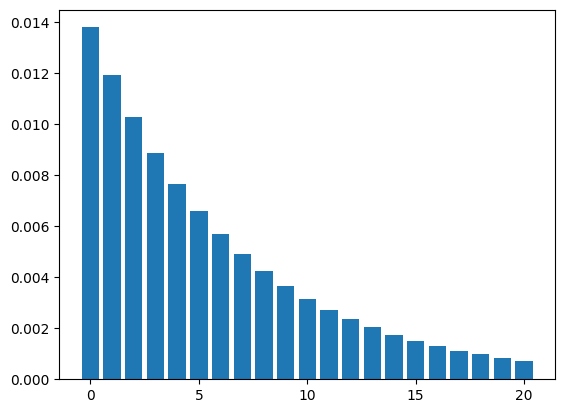

In [20]:
plt.figure()
plt.bar([i for i in range(0, len(ar_weights))], ar_weights)
plt.show()

In [21]:
np.save(f'../models/{symbol}', ar_weights)

In [22]:
signals = generate_signals(train_data, ar_weights)

In [23]:
def sma(returns, window):
    signals = []
    for i in range(len(returns)):
        if i < window:
            signals.append(0)  # Not enough data to calculate SMA
        else:
            current_sma = sum(returns[i-window:i]) / window
            prev_sma = sum(returns[i-window-1:i-1]) / window
            if current_sma > prev_sma:
                signals.append(current_sma)  # SMA rising
            elif current_sma < prev_sma:
                signals.append(current_sma)  # SMA falling
            else:
                signals.append(0)  # No change
    return signals

sma_sig = sma(np.asarray(train_data['returns'].reset_index(drop=True)), 4)

In [24]:
signals

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 np.float64(0.017857871918671983),
 np.float64(0.03540669748371733),
 np.float64(0.015681376492648193),
 np.float64(0.013238409747570627),
 np.float64(0.017270320260180067),
 np.float64(0.055402243738657105),
 np.float64(0.05531727352101138),
 np.float64(0.044860477378907394),
 np.float64(0.02773163522846494),
 np.float64(0.041420720327606395),
 np.float64(0.06212701643542444),
 np.float64(0.047360269852307464),
 np.float64(0.06105690528678013),
 np.float64(0.06759644753828108),
 np.float64(0.058822900830323134),
 np.float64(0.0633669056802106),
 np.float64(0.06291155034415401),
 np.float64(0.043789769345181286),
 np.float64(0.021147301619353975),
 np.float64(0.02397905742967108),
 np.float64(-0.00038462099673833555),
 np.float64(-0.02885997456058971),
 np.float64(-0.010563449933287306),
 np.float64(-0.002779386171937417),
 np.float64(-0.027891110508596023),
 np.float

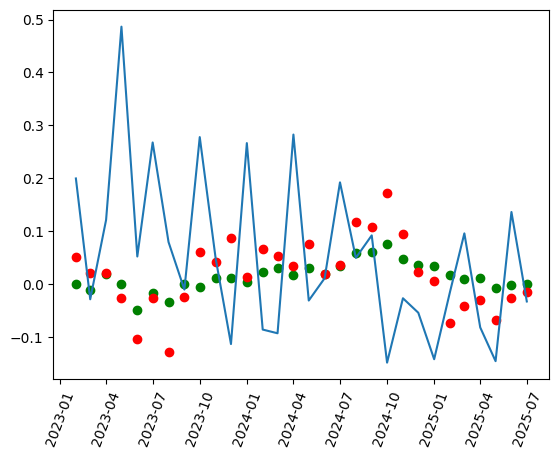

In [25]:
plt.figure()
plt.plot(data['date'][-30:], data['returns'][-30:])
plt.scatter(data['date'][-30:], signals[-30:], color='green')
plt.scatter(data['date'][-30:], sma_sig[-30:], color='red')
#plt.vlines(sell_dates[-30:], -0.05, 0.05, color='red')
plt.xticks(rotation=70)
plt.show()

In [26]:
buy_dates, sell_dates = get_action_dates(train_data, signals)


c:\Users\adity\markov-switching-model-trading\src\trend.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  buy_dates.append(data['date'][i])
c:\Users\adity\markov-switching-model-trading\src\trend.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sell_dates.append(data['date'][i])


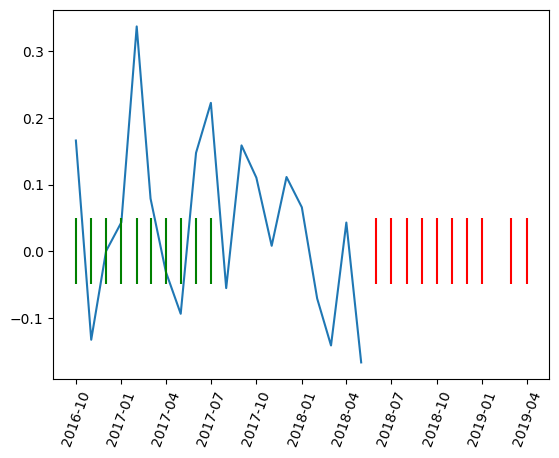

In [27]:
plot_actions(train_data, buy_dates, sell_dates, signals)

In [28]:
test_signals = generate_signals(test_data, ar_weights)

In [29]:
test_buy_dates, test_sell_dates = get_action_dates(test_data, test_signals)

ValueError: x and y must be the same size

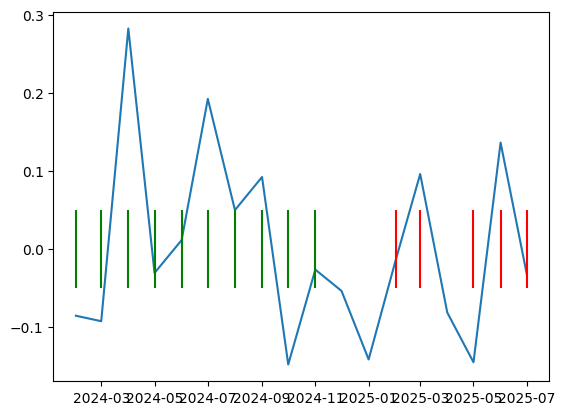

In [30]:
plot_actions(test_data, test_buy_dates, test_sell_dates, test_signals)